### Reproduce Extended Data Fig1 in Vecellio et al 2023

In [6]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmaps
from matplotlib import gridspec
from shapely import geometry
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [20]:
# read the number of hours with Tw>35C
hothour=xr.open_dataset('./data/Tw_hothours35C_preindustrial.nc').hours*3
# read the number of person-hours with Tw>35C
pophour=xr.open_dataset('./data/SSP_2050_pop_x_hothours_Tw35C.nc').hours*3

In [15]:
def interp(data):
    data2=data.copy()
    longitude=data.lon
    longitude=xr.where(longitude>180,longitude-360,longitude)
    data2['lon']=longitude
    data2=data2.sortby('lon')
    loc=0
    locnew=np.array([loc-1,loc-0.75,loc-0.5,loc-0.25,loc,loc+0.25,loc+0.5,loc+0.75,loc+1])
    tmp=data2.drop_sel(lon=locnew)
    tmp2=tmp.interp(lon=data2.lon.values)
    longitude2=tmp2.lon
    longitude2=xr.where(longitude2<0,longitude2+360,longitude2)
    tmp2['lon']=longitude2
    return tmp2.sortby('lon')

In [18]:
# define colormap
color=np.array([
    [225,225,225],
    [255, 245, 204],
    [255, 230, 112],
    [255, 204,  51],
    [255, 175,  51],
    [255, 153,  51],
    [255, 111,  51],
    [255,  85,   0],
    [230,  40,  30],
    [200,  30,  20]])

cmap=mpl.colors.ListedColormap(color/255.)

In [16]:
def subplot(data,axis,norm,cmap,LON,LAT,landmask):
    g=axis.pcolormesh(LON, LAT,data.pipe(interp).where(landmask==0),
                      transform=ccrs.PlateCarree(),
                      cmap=cmap,norm=norm,rasterized=True) 
    axis.coastlines(linewidth=0.5,resolution='50m') # add coastlines
    axis.set_title('')
    axis.set_extent([-169.999,189.999,-60,75]) # set extent of the map to exclude high latitudes
    return g
def curve(x,y,axis,c,linestyle,label,marker,linewidth):
    g=axis.plot(x,y,color=c,linestyle=linestyle,label=label,marker=marker,linewidth=linewidth)
    return g

def plot(data,pop):
    fig = plt.figure(figsize=[12,5])
    levels=[0,3,8,24,56,112,168,240,480,720]
    norm=mpl.colors.BoundaryNorm(levels,ncolors=len(levels),extend='max')
    clabel='Annual hot hours'
    
    LON,LAT=np.meshgrid(data.lon.values,data.lat.values)
    landmask= regionmask.defined_regions.natural_earth.land_110.mask(data,lon_name="lon",lat_name="lat")
    
    spec = gridspec.GridSpec(ncols=2, nrows=3,width_ratios=[3,1],height_ratios=[1,5,1],wspace=0.05)
    ax0 = fig.add_subplot(spec[0:5], projection=ccrs.Robinson(central_longitude=10))
    ax1 = fig.add_subplot(spec[3])
    
    g=subplot(data,ax0,norm,cmap,LON,LAT,landmask)    
    curve(pop.X.values,pop.mean('model').values/1e9,ax1,'k','solid','1 week','o',1.5)
    ax1.fill_between(pop.X.values,
                     pop.quantile(0.1,'model').values/1e9,
                     pop.quantile(0.9,'model').values/1e9,
                     alpha=0.2,color='black')
    
    ax1.set_xlabel('Global warming target ($^\circ$C)',fontsize=12)
    ax1.set_ylabel('person-hours (billions)',fontsize=12)
    ax1.set_xlim([0.97,4.03])
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.yaxis.set_ticks_position("right") # y axis ticks on the right
    ax1.yaxis.set_label_position("right") # y axis labels on the right
    
    cb=fig.colorbar(g,ax=ax0,orientation='horizontal',pad=0.04,shrink=0.8,fraction=.08,aspect=50,ticks=levels)
    cb.set_label(label=clabel, size=14)
    cb.ax.tick_params(labelsize=12)


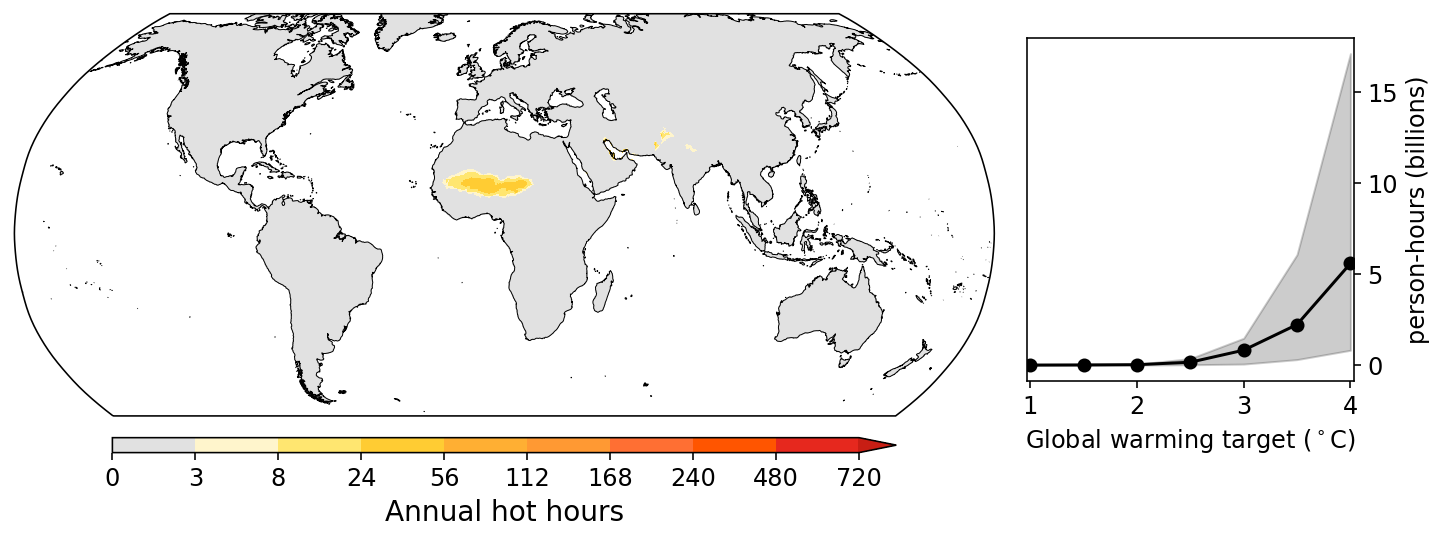

In [21]:
plot(hothour,pophour)